### Autoencoder

AutoEncoder 은 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경 망(비지도 학습) 이다. 
<div><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile2.uf.tistory.com%2Fimage%2F996C93475BDC97C00AE328" height="100%" width="100%" /></div><br>

아래 링크는 AutoEncoder에 관한 개념 설명이 나와있다.  
<a href="https://wjddyd66.github.io/tensorflow/2019/08/28/Tensorflow-AutoEncoder.html">Auto Encoder</a>


### 1. Settings
#### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#### 2) Set hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

### 2. Data

#### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#### 2) Set DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

### Stacked AutoEncoder

Stacked AutoEncoder는 여러개의 히든 레이어를 가지는 Auto Encoder이며, 레이어를 추가할수록 AutoEncoder가 더 복잡한 코딩을 학습할 수 있다.  
Stacked AutoEncoder는 아래의 그림과 같이 가운데 히든레이어를 기준으로 대칭인 구조를 가진다.  

<div><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile9.uf.tistory.com%2Fimage%2F99F1DE4A5BDC983D09BAED" height="100%" width="100%" /></div><br>

이번 Model은 MNIST를 분류하는 Stacked AutoEncoder를 구현하는 것 이다.  
<br>
**Encoder:** [batch_size,1,28,28] -> x.view(batch_size,-1) -> [batch_size,784] -> nn.Linear(28 * 28, 20) -> [batch_size,20]  
<br>
**Decoder:** [batch_size,20] -> nn.Linear(20 , 28 * 28) -> [batch_size,784] -> self.decoder(encoded).view(batch_size,1,28,28) -> [batch_size,1,28,28]  


#### 1) Model

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Linear(28*28,20)
        self.decoder = nn.Linear(20,28*28)   
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

#### 2) Loss func & Optimizer

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


#### 3) Train 

In [7]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        
    if j % 1000 == 0:
        print(loss)
        loss_arr.append(loss.cpu().data.numpy()[0])

#### 4) Check with Train Image

AutoEncoder의 Stacked AutoEncoder는 입력과 출력이 같기 때문에 Input Data만으로도 Model의 성능을 판단할 수 있다.

torch.Size([256, 28, 28])


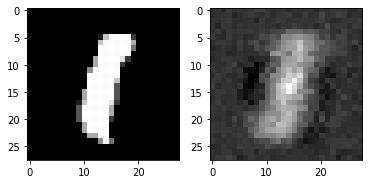

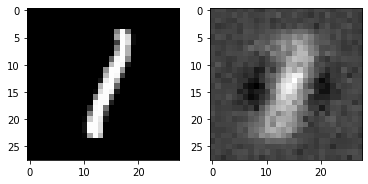

In [8]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

#### 5) Check with Test Image

In [9]:
with torch.no_grad():
  for i in range(1):
      for j,[image,label] in enumerate(test_loader):
          x = image.to(device)

          optimizer.zero_grad()
          output = model.forward(x)

      if j % 1000 == 0:
          print(loss)        

torch.Size([256, 28, 28])


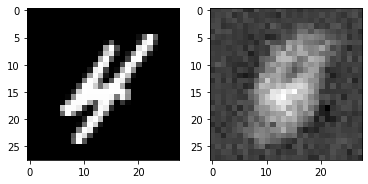

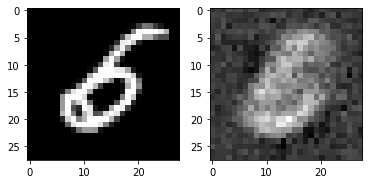

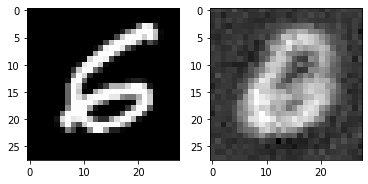

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

### Convolution Stacked AutoEncoder

Stacked AutoEncoder의 Model이 성능이 안좋은 것을 확인하여 Model을 ANN구조가 아닌 CNN의 구조로서 다시 작성한다.  

중요한것은 **Convolution Stacked AutoEncoder에서의 Decoder**이다.  
결국 줄어든 Feature 특성을 다시 Input Size에 맞게 늘리기 위해서는 Convolution연산과 같은 방법으로서 Data를 늘려야 하기 때문이다.  
이러한 Convolution의 역 연산을 **DeConvolution**이라 한다.

Pytorch는 이러한 연산을 **ConvTranspose2d**을 통하여 지원한다.

<code>torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')</code>
- stride: controls the stride for the cross-correlation.
- padding: controls the amount of implicit zero-paddings on both sides for dilation * (kernel_size - 1) - padding number of points. See note below for details.
- output_padding: controls the additional size added to one side of the output shape. See note below for details.
- dilation: controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.
- groups: controls the connections between inputs and outputs

아래와 같은 가정이 있을때 **간단한 수식을 사용하여 Output의 차원의 크기를 쉽게 예측**할 수 있다.  

- 입력 크기: (N, C_{in}, H_{in}, W_{in})
- 출력 크기: (N, C_{out}, H_{out}, W_{out})


<p>$$H_{out}=(H_{in}−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1$$</p>
<p>$$W_{out}=(W_{in}−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1$$</p>


좀 더 명확히 알아보기 위하여 그림으로서 알아보자.  
아래 그림의 Parameter는 다음과 같다.
- input size: 2 x 2
- output size: 4 x 4
- kernel size: 3 x 3
- stride: 1
- padding: 0
- out_padding: 0

<img src="https://i.stack.imgur.com/YyCu2.gif" alt="" width="208" height="233">

위와 같은 조건에서 Parameter의 Stride를 2로 증가시키고 Padding을 넣었을 경우의 Deconvolution의 결과이다.  
<img src="https://i.stack.imgur.com/f2RiP.gif" alt="" width="208" height="233">

위의 두 그림에서 이해하기 힘든 **Deconvolution에서의 Padding과 Out_padding**에 대해서 좀 더 살펴보자.  

#### Input data

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])


tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

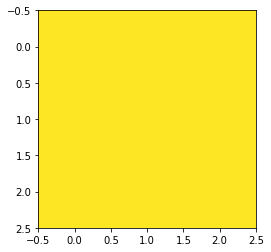

In [22]:
# 입력으로 1로 채워진 텐서를 생성합니다.
img = torch.ones(1,1,3,3)
print(img)

plt.imshow(img.numpy()[0,0,...],vmin=0)

transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0, bias=False)
# 결과를 확인하기 쉽게 전치 컨볼루션 연산의 가중치를 1로 초기화합니다.
init.constant_(transpose.weight.data,1)

#### Kernel Size=3, stride=1, padding=0, output_padding=0

tensor([[[[1., 2., 3., 2., 1.],
          [2., 4., 6., 4., 2.],
          [3., 6., 9., 6., 3.],
          [2., 4., 6., 4., 2.],
          [1., 2., 3., 2., 1.]]]], grad_fn=<ConvTranspose2DBackward>) torch.Size([1, 1, 5, 5])


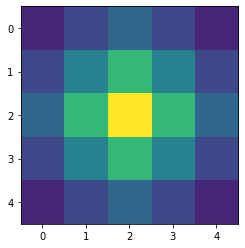

In [23]:
out = transpose(img)
print(out,out.size())

plt.imshow(out.detach().numpy()[0,0,...],vmin=0)
plt.show()

#### Kernel Size=3, stride=2, padding=0, output_padding=0

Stride증가시 Output Size 커짐

tensor([[[[1., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 1.]]]], grad_fn=<ConvTranspose2DBackward>) torch.Size([1, 1, 7, 7])


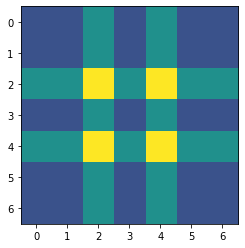

In [24]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=0, bias=False)
init.constant_(transpose.weight.data,1)
out = transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

#### Kernel Size=3, stride=2, padding=1, output_padding=0

Padding 추가시 결과값에서 Outline padding크기만큼 제거

tensor([[[[1., 2., 1., 2., 1.],
          [2., 4., 2., 4., 2.],
          [1., 2., 1., 2., 1.],
          [2., 4., 2., 4., 2.],
          [1., 2., 1., 2., 1.]]]], grad_fn=<ConvTranspose2DBackward>) torch.Size([1, 1, 5, 5])


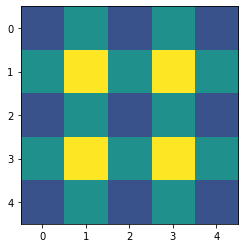

In [25]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=0, bias=False)
init.constant_(transpose.weight.data,1)
out = transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

## Kernel Size=3, stride=2, padding=0, output_padding=1

out_padding 추가시 out_padding크기만큼 결과값 width, height증가

tensor([[[[1., 1., 2., 1., 2., 1., 1., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [2., 2., 4., 2., 4., 2., 2., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [2., 2., 4., 2., 4., 2., 2., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]],
       grad_fn=<ConvTranspose2DBackward>) torch.Size([1, 1, 8, 8])


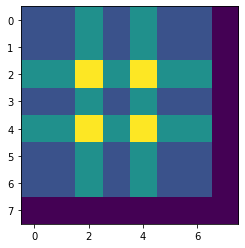

In [26]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1, bias=False)
init.constant_(transpose.weight.data,1)
out=transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

#### 1) Model

Encoder: 기존에 사용하던 Convolution으로서 Input Size보다 작아지게 구성  
Decoder: DeConvolution을 사용하여 Input Size만큼 크기를 키움

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    


In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out



#### 2) Loss func & Optimizer

Loss Function에서 중요한 점은 Encoder와 Decoder의 Parameter를 동시에 학습시키기 위해 묶어서 Optimizer에적용시켜야 한다.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


#### 3) Train 

In [18]:
# 모델을 불러오는 방법입니다.
# 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        # 모델 저장하는 방법
        # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
        print(loss)



--------model not restored--------



#### 4) Check with Train Image

torch.Size([256, 28, 28])


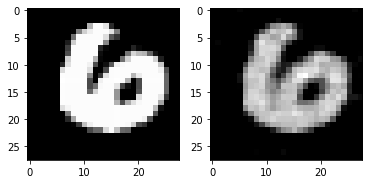

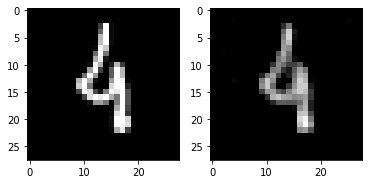

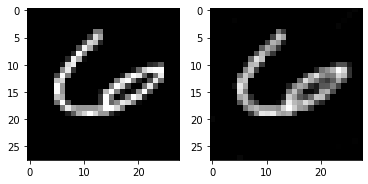

In [15]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

#### 5) Check with Train Image

In [16]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([256, 28, 28])


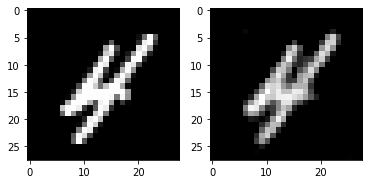

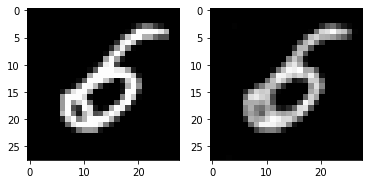

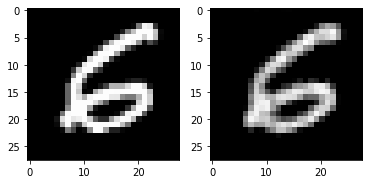

In [17]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()